# Data Science Capstone Project Assignment Notebook

In [101]:
import pandas as pd
import numpy as np
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


# Segmenting and Clustering Neighborhoods in Canada

If The beautifulSoup is not installed in your machine run this codes:
    
conda install -c anaconda lxml in cell 1

conda install -c anaconda beautifulsoup in cell 2



If lxml is not installed in your machine run the following line of code:

conda install -c anaconda lxml

In [102]:
import requests
from bs4 import BeautifulSoup
import pandas

In [103]:
website_text = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_text,'xml')
table = soup.find('table',{'class':'wikitable sortable'})

In [104]:
table_rows = table.find_all('tr')
data = []
for row in table_rows:
    td=[]
    for t in row.find_all('td'):
        td.append(t.text.strip())
    data.append(td)
df = pandas.DataFrame(data, columns=['PostalCode', 'Borough', 'Neighborhood'])

In [105]:
df = df[~df['Borough'].isnull()]  # to filter out bad rows
df.drop(df[df.Borough == 'Not assigned'].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(lambda x: ','.join(x)).reset_index()
df['Neighborhood'].replace('Not assigned',df['Borough'],inplace=True)
df

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,Kingsview Village / St. Phillips / Martin Grov...
101,M9V,Etobicoke,South Steeles / Silverstone / Humbergate / Jam...


In [106]:
df.shape

(103, 3)

# geographical coordinates of the neighborhoods

In [107]:
import pandas as pd

url="https://cocl.us/Geospatial_data"
coordinates=pd.read_csv(url)

In [108]:
print('The coordinates dataframe shape is', coordinates.shape)
coordinates.head()

The coordinates dataframe shape is (103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Adding coordinates to the neighborhood dataframe using the postcodes as keys to join

In [109]:
postalcodes_with_coordinates = df.join(coordinates.set_index("Postal Code"), on="PostalCode")

postalcodes_with_coordinates.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,Kennedy Park / Ionview / East Birchmount Park,43.727929,-79.262029
7,M1L,Scarborough,Golden Mile / Clairlea / Oakridge,43.711112,-79.284577
8,M1M,Scarborough,Cliffside / Cliffcrest / Scarborough Village West,43.716316,-79.239476
9,M1N,Scarborough,Birch Cliff / Cliffside West,43.692657,-79.264848


# EXPLORING AND CLUSTERING 

### With the coordinates of each postal code, a map of Toronto with markers indicating the Postcode position is generated

In [110]:
import folium

In [111]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=10)

for location in postalcodes_with_coordinates.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

Postal codes are not evenly spaced, and the area cover by some of them, using a radius of 500 meters, overlaps. A different radius for each postcode results in a better venues search because that will avoid misrepresentation of the number of venues per postcode caused by too large or low radius values.

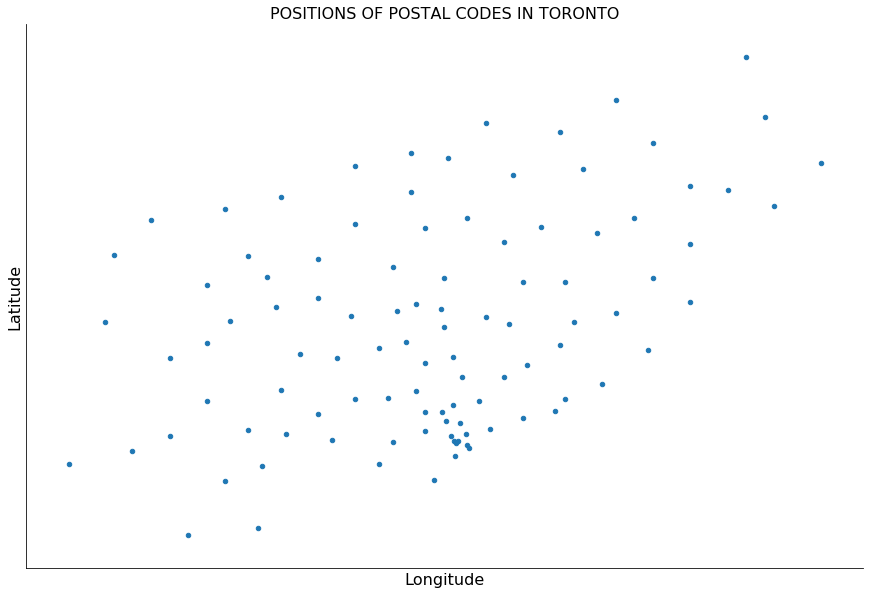

In [112]:
import matplotlib.pyplot as plt

X = postalcodes_with_coordinates[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('POSITIONS OF POSTAL CODES IN TORONTO', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

Finding the closest points for each postcode

In [113]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [114]:
coordinates = postalcodes_with_coordinates[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])


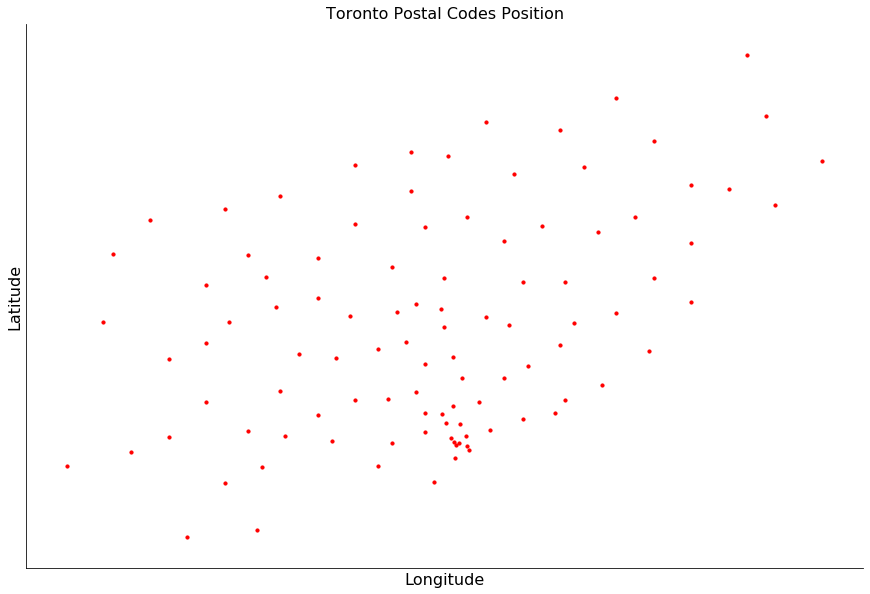

In [115]:
fig = plt.figure(figsize=(15,10))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

In [116]:
#Adding Distance column
from math import isnan

for lat, lng, idx in zip(postalcodes_with_coordinates['Latitude'], postalcodes_with_coordinates['Longitude'], postalcodes_with_coordinates.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    postalcodes_with_coordinates.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
postalcodes_with_coordinates.tail()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Distance
98,M9N,York,Weston,43.706876,-79.518188,814.0
99,M9P,Etobicoke,Westmount,43.696319,-79.532242,814.0
100,M9R,Etobicoke,Kingsview Village / St. Phillips / Martin Grov...,43.688905,-79.554724,993.0
101,M9V,Etobicoke,South Steeles / Silverstone / Humbergate / Jam...,43.739416,-79.588437,1302.0
102,M9W,Etobicoke,Northwest,43.706748,-79.594054,1830.0


Plotting with new radius to avoid overlapping 

In [142]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postalcodes_with_coordinates.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

## OBTAIN ALL VENUES

In order to get the venues in the perimeter of each Postal code, it is necessary to get the geographical coordinates (lat and lng) of each one of those and add them to the dataframe. The coordinates are in the csv file 'Geospatial_Coordinates.csv".

In [118]:
CLIENT_ID = 'LRS13OZD3R4LOD14F2UCFDLTCXKNW1BJSKEJRQU1NEEYYCT1' 
CLIENT_SECRET = 'SY2BW5FACV5K3XMK4ITTD4NDJW0HVGCPXUEEX1T1JCKPNURI' 
VERSION = '20181102'

100 Postal Codes in a raius of 500 metre

In [119]:
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [120]:
first_postcode = postalcodes_with_coordinates.iloc[2, :]
url = format_url(first_postcode['Latitude'], first_postcode['Longitude'], first_postcode['Distance'])

url

'https://api.foursquare.com/v2/venues/explore?client_id=LRS13OZD3R4LOD14F2UCFDLTCXKNW1BJSKEJRQU1NEEYYCT1&client_secret=SY2BW5FACV5K3XMK4ITTD4NDJW0HVGCPXUEEX1T1JCKPNURI&ll=43.7635726,-79.1887115&v=20181102&radius=1205.0&limit=100'

In [121]:
import json
from pandas.io.json import json_normalize

In [122]:
#function to get batch of venues as a dataframe
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

In [123]:
venues_df = get_venues(url)

venues_df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups
0,e-0-4bc366dab492d13a51b2a860-0,0,"[{'summary': 'This spot is popular', 'type': '...",4bc366dab492d13a51b2a860,Chick-N-Joy,4449 Kingston Road,at Lawrence and Morningside,43.768752,-79.187982,"[{'label': 'display', 'lat': 43.76875171771289...",579,M1E 2N7,CA,Scarborough,ON,Canada,[4449 Kingston Road (at Lawrence and Morningsi...,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",0,[]
1,e-0-4b3a9504f964a520646a25e3-1,0,"[{'summary': 'This spot is popular', 'type': '...",4b3a9504f964a520646a25e3,LCBO,4525 Kingston Rd.,at Lawrence Ave. E,43.771462,-79.184384,"[{'label': 'display', 'lat': 43.77146181777272...",944,M1E 2P1,CA,Toronto,ON,Canada,"[4525 Kingston Rd. (at Lawrence Ave. E), Toron...","[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",0,[]
2,e-0-4ba164fdf964a52039b337e3-2,0,"[{'summary': 'This spot is popular', 'type': '...",4ba164fdf964a52039b337e3,Bulk Barn,4525 Kingston Rd,Morningside Crossing,43.771342,-79.184341,"[{'label': 'display', 'lat': 43.77134173380578...",933,NaN,CA,West Hill,ON,Canada,"[4525 Kingston Rd (Morningside Crossing), West...","[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",0,[]
3,e-0-4c9fdb04542b224bca4201a0-3,0,"[{'summary': 'This spot is popular', 'type': '...",4c9fdb04542b224bca4201a0,Little Caesars Pizza,4218 Lawrence Avenue East,NaN,43.769046,-79.184386,"[{'label': 'display', 'lat': 43.76904597684398...",701,M1E 4X9,CA,Scarborough,ON,Canada,"[4218 Lawrence Avenue East, Scarborough ON M1E...","[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",0,[]
4,e-0-4beca2f9d6e676b0538764d4-4,0,"[{'summary': 'This spot is popular', 'type': '...",4beca2f9d6e676b0538764d4,Booster Juice,"4525 Kingston Road, Unit #H8",at Collinsgrove Rd.,43.770668,-79.184150,"[{'label': 'display', 'lat': 43.77066813, 'lng...",870,M1E 2P1,CA,Scarborough,ON,Canada,"[4525 Kingston Road, Unit #H8 (at Collinsgrove...","[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",0,[]


In [124]:
#function to clean the venues dataframe
def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",43.768752,-79.187982,Chick-N-Joy
1,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",43.771462,-79.184384,LCBO
2,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",43.771342,-79.184341,Bulk Barn
3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.769046,-79.184386,Little Caesars Pizza
4,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",43.770668,-79.184150,Booster Juice


In [125]:
#function that extract the category name
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df.tail()

,Category,Lat,Lng,Name
20,Supermarket,43.770184,-79.184852,Food Basics
21,Pizza Place,43.768413,-79.187930,Pizza Pizza
22,Automotive Shop,43.772666,-79.184443,Kal Tire
23,Gym / Fitness Center,43.768867,-79.176958,Heron Park Community Centre
24,Park,43.769327,-79.177201,Heron Park


Now obtain venues for each postal code

In [126]:
#function to construct the dataframe with all the venues (max 100 venues per postal code)
def get_all_venues(postcodes, lat, lng, radius):
    venues_list=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues

In [127]:
all_venues = get_all_venues(postalcodes_with_coordinates['PostalCode'], postalcodes_with_coordinates['Latitude'], postalcodes_with_coordinates['Longitude'], postalcodes_with_coordinates['Distance'])

print('The total number of venues returned is ', all_venues.shape[0])

all_venues.tail()

The total number of venues returned is  3320


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3315,M9W,43.706748,-79.594054,Willows Dining Room,43.715243,-79.605224,American Restaurant
3316,M9W,43.706748,-79.594054,Planet Fitness,43.719063,-79.595205,Gym / Fitness Center
3317,M9W,43.706748,-79.594054,Hwy 427 at 409,43.696983,-79.607019,Intersection
3318,M9W,43.706748,-79.594054,Cinnabon,43.720284,-79.600311,Bakery
3319,M9W,43.706748,-79.594054,Hwy 409 at Martin Grove,43.698814,-79.575069,Intersection


In [128]:
print('Total Toronto postcodes:', postalcodes_with_coordinates['PostalCode'].shape[0])
print('Total Toronto postcodes with venues:', all_venues['Postcode'].unique().shape[0])

Total Toronto postcodes: 103
Total Toronto postcodes with venues: 102


The Postal code with no venues is one is pulled using the below code

In [129]:
postcodes_diff = np.setdiff1d(postalcodes_with_coordinates['PostalCode'].values,all_venues['Postcode'].unique())
postalcodes_with_coordinates[postalcodes_with_coordinates['PostalCode']==postcodes_diff[0]]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Distance
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,111.0


### Analysis of the data of the venues

In [130]:
venues_in_postcode = all_venues.groupby('Postcode').count()
venues_in_postcode = pd.DataFrame(list(zip(venues_in_postcode.index, venues_in_postcode['Venue'])), 
                                  columns=['Postcode', '# of Venues']).set_index('Postcode').join(postalcodes_with_coordinates[['PostalCode','Distance']].set_index('PostalCode'), on='Postcode').reset_index()
venues_in_postcode['Distance'] = np.int64(venues_in_postcode['Distance'])
venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as # of venues

venues_in_postcode.head(10)

,Postcode,# of Venues,Distance
0,M1B,37,1698
1,M1C,11,1625
2,M1E,25,1205
3,M1G,4,913
4,M1H,22,913
5,M1J,22,1301
6,M1K,26,1112
7,M1L,33,1052
8,M1M,16,1112
9,M1N,15,1297


In [131]:
venues_in_postcode[['# of Venues']].describe()

,# of Venues
count,103.000000
mean,32.233010
std,24.628297
min,0.000000
25%,12.500000
50%,26.000000
75%,44.000000
max,100.000000


### Number of Venues Per Postal Code Graph

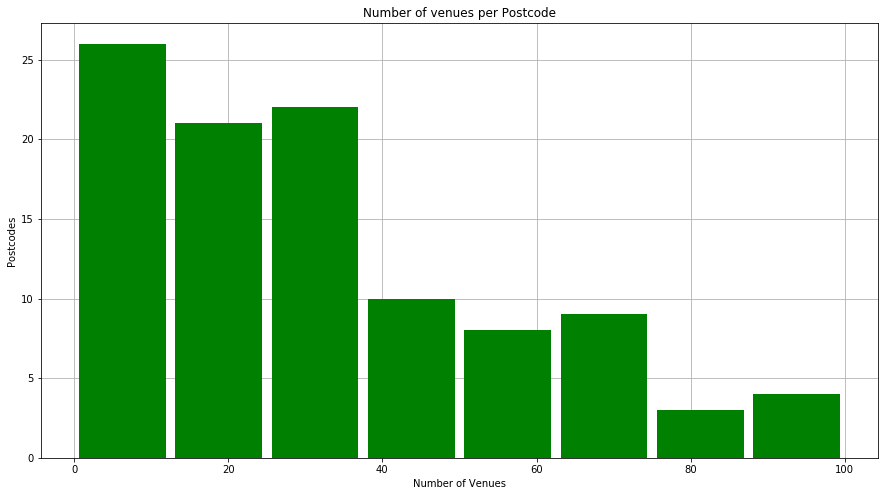

In [133]:
venues_in_postcode['# of Venues'].hist(bins=8, figsize=(15,8),zorder=2, rwidth=0.9,color='green')

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Number of venues per Postcode')
plt.show()

Represent the venues per postcode in terms of density

In [134]:
density_venues_in_postcode = all_venues.groupby('Postcode').count()

density_venues_in_postcode = pd.DataFrame(list(zip(density_venues_in_postcode.index, density_venues_in_postcode['Venue'])), 
                                  columns=['Postcode', 'Density']).set_index('Postcode').join(postalcodes_with_coordinates[['PostalCode','Distance']].set_index('PostalCode'), on='Postcode').reset_index()
density_venues_in_postcode['Density'] = np.int64(density_venues_in_postcode['Density']/(density_venues_in_postcode['Distance']/1000)) #distance in km
density_venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as density

density_venues_in_postcode.head(10)

,Postcode,Density,Distance
0,M1B,21,1698.0
1,M1C,6,1625.0
2,M1E,20,1205.0
3,M1G,4,913.0
4,M1H,24,913.0
5,M1J,16,1301.0
6,M1K,23,1112.0
7,M1L,31,1052.0
8,M1M,14,1112.0
9,M1N,11,1297.0


### Clustering of Postal Codes follows

In [135]:
from sklearn.cluster import KMeans

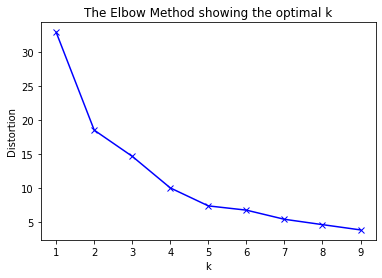

In [136]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_venues_in_postcode['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_venues_in_postcode['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Number of clusters is optimum at 5

In [137]:
num_clusters = 5

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[0 0 0 0 0 0 0 4 0 0 4 4 4 4 4 4 0 0 4 0 0 4 2 4 0 4 4 4 4 0 0 0 0 0 0 0 0
 2 2 4 4 1 4 1 0 0 4 2 0 2 0 2 3 2 3 4 2 1 3 2 1 4 0 0 4 2 1 4 2 1 4 4 0 0
 4 4 1 2 0 0 4 2 2 2 0 4 4 4 4 4 0 4 0 0 0 0 0 0 0 0 0 0 0]


In [138]:
density_venues_in_postcode['Cluster'] = k_means.labels_
density_venues_in_postcode.head(10)

,Postcode,Density,Distance,Cluster
0,M1B,21,1698.0,0
1,M1C,6,1625.0,0
2,M1E,20,1205.0,0
3,M1G,4,913.0,0
4,M1H,24,913.0,0
5,M1J,16,1301.0,0
6,M1K,23,1112.0,0
7,M1L,31,1052.0,4
8,M1M,14,1112.0,0
9,M1N,11,1297.0,0


Examining Clusters Centroid and Postal Codes

In [139]:
centroids = np.int64(round(density_venues_in_postcode.groupby('Cluster').mean()['Density']))
frecuency = density_venues_in_postcode.groupby('Cluster').count()['Postcode']

cluster_info = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','Postcodes']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Postcodes
0,0,13,45
1,4,39,33
2,2,82,15
3,1,126,7
4,3,225,3


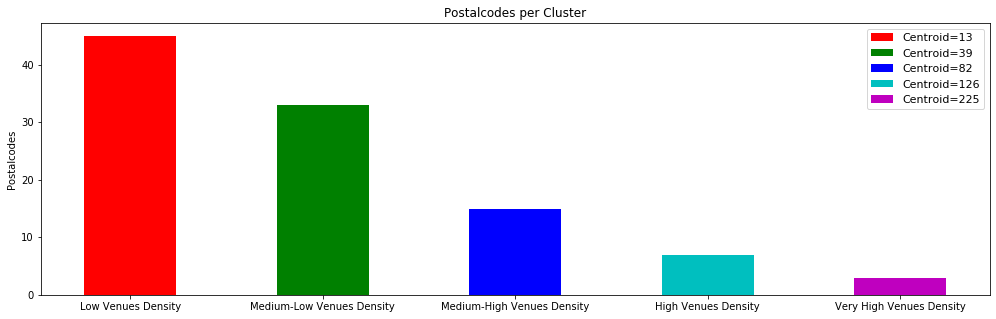

In [141]:
fig, ax = plt.subplots(figsize=(17,5))
clusters= ['Low Venues Density','Medium-Low Venues Density','Medium-High Venues Density','High Venues Density','Very High Venues Density']
colors = ['r','g','b','c','m']
legend = []

for id, cluster in enumerate(clusters):
    legend.append('Centroid={}'.format(cluster_info['Centroid'][id]))
    bar = ax.bar(cluster, cluster_info['Postcodes'][id], 0.48, color=colors[id])

ax.set_ylabel('Postalcodes')
ax.set_title('Postalcodes per Cluster')
# ax.set_facecolor((1,1,1))
# ax.grid(True, axis='y',color='k', linestyle='-', linewidth=1)

plt.legend(legend, fontsize=11)

plt.show()